# Aims
- Test making occupancy data sets
- import pickle  data and put it into ft entity sets
- check that can select only records that are active for a window in a morning

In [1]:
#%cd ./flosp
import pandas as pd
import numpy as np
import seaborn as sns
import featuretools as ft
#import flosp
#import bradlib as bl
sns.set()

# from core import create_timeseries_from_events, make_callender_columns

# get raw data

In [2]:
IP = pd.read_pickle('./../../../3_Data/EDclassification/cleanSPELL.pkl')

In [3]:
IP.head(2)

,pseudo_patient_number,age_at__admission,gender,spell_number,admission_date,discharge_date,admission_method_code,admission_method_description,length_of_stay_days,admission_source_code,...,date_of_death,ward_code,ward_code_description,ward_stay_start_date,ward_stay_end_date,LOCATION_NUMBER,admission_type,ADM_METHOD_simple,ADM_TYPE,ward_moves
0,353232538008,79,2,6222150,2009-04-29 14:19:00,2009-04-29 15:08:00,13,ELECTIVE PLANNED,0,19,...,08-MAY-18 00:00,1160,UROLOGY ENDOSCOPY SGH,2009-04-29 14:19:00,2009-04-29 15:08:00,1,0,other,Day Case,1
1,352434524354,24,2,6279602,2009-08-20 23:00:00,2009-08-21 02:00:00,31,MATERNITY ANTE PARTUM,1,19,...,NaN,1269,DELIVERY SUITE,2009-08-20 23:00:00,2009-08-21 02:01:00,1,0,Maternity,Non-Elective,1


In [4]:
IP.rename(columns={'age_at__admission':'age'},inplace=True)

In [5]:
IP.shape

(1315333, 25)

######## reduce number of records for simplicity - delete after
IP = IP[IP.discharge_date > pd.datetime(2018,7,1)]

#### Make df contaiing all the time cutoffs that I want to calc status of hospital for...

In [6]:
IP.admission_date.min()

Timestamp('2009-04-01 00:05:00')

In [7]:
IP.admission_date.max()

Timestamp('2018-09-30 23:50:00')

In [8]:
start = pd.datetime(2012,1,1,7)
# end = ED.arrival.max()
end = pd.datetime(2018,10,1,7)
ct = pd.DataFrame(pd.DatetimeIndex(freq='d',start=start,end=end),columns=['time'])
ct['day'] = ct.time.apply(lambda x: x.date())
ct.set_index('time',inplace=True)
ct.head()

,day
time,
2012-01-01 07:00:00,2012-01-01
2012-01-02 07:00:00,2012-01-02
2012-01-03 07:00:00,2012-01-03
2012-01-04 07:00:00,2012-01-04
2012-01-05 07:00:00,2012-01-05


In [9]:
ct.shape

(2466, 1)

input: patient record df, df with times
method:

make df object that is empty
filter patrecords for those valid at the time
calc all values above
assign value to df

In [10]:
def get_status_at_hours(df,hours_required):
    """
    Input
    -----
    df, pandas df , patient records at IP spell level.
    hour_requried, df, dataframe containing index of hours to calculate hour status for.
    
    Output
    ------
    hourly_status, df, index contains hour, columns a number of different measures
    
    """
    # instigate hourly_status df as empty
    hourly_status = hours_required.copy()
    # create new empty cols for status calculations
    columns_list = ['count','count_elec']#,'IPcount_nonelec'] # actually this may not be required
    for column in columns_list:
        ct[column] = np.nan
    
    
    # loop for hours_required, start with 2
    for index, row in hours_required.iterrows():
#         print(index, row['day'])
        relevant_records = get_active_records(df,index) # get active records
        
        # CALC STATS
        hourly_status.loc[index,'count'] = calc_nopat(relevant_records) # calc no active records
        no_elec = calc_admtype(relevant_records, hourly_status, index)
        calc_age(relevant_records,hourly_status,index)
#         hourly_status.loc[index,'IPcount_elec'] = no_elec
#         relevant_records['ADM_METHOD_simple']
#         relevant_records['ADM_TYPE']
        

    
    # calc new values possible
    #adm_type
    hourly_status['prop_nonelec'] = hourly_status['count_nonelec']/ hourly_status['count']
    
    # assign to hourly_status
    
    
    return(hourly_status)

# search for relevant records at the hour
def get_active_records(df, datetime):
    "filters df for records that patients were in hosptial at that hour."
    relevant_records = df[(df.admission_date <= datetime) & (df.discharge_date > datetime)]
    return(relevant_records)

# calc each value
def calc_nopat(relevant_records):
    ""
    no_patients = len(relevant_records)
    return(no_patients)

def calc_age(relevant_records, hourly_status, index):
    hourly_status.loc[index,'age_mean'] = relevant_records.age.mean()
    
    hourly_status.loc[index,'age_std'] = relevant_records.age.std()
    
    hourly_status.loc[index,'age_skew'] = relevant_records.age.skew()
    return

def calc_admtype(relevant_records, hourly_status, index):
    ""
    no_nelec = (relevant_records['ADM_TYPE'] == 'Non-Elective').sum() #, 'Elective', 'Day Case'
    no_elec = (relevant_records['ADM_TYPE'] == 'Elective').sum()
    # assign values
    hourly_status.loc[index,'count_elec'] = no_elec
    hourly_status.loc[index,'count_nonelec'] = no_nelec
    return

fm = get_status_at_hours(IP, ct)

In [11]:
fm.head()

,day,count,count_elec,count_nonelec,age_mean,age_std,age_skew,prop_nonelec
time,,,,,,,,
2012-01-01 07:00:00,2012-01-01,974.0,112.0,853.0,62.297741,26.585503,-0.897309,0.875770
2012-01-02 07:00:00,2012-01-02,1008.0,98.0,899.0,62.568452,26.251803,-0.901787,0.891865
2012-01-03 07:00:00,2012-01-03,1043.0,99.0,925.0,62.461170,26.026363,-0.868892,0.886865
2012-01-04 07:00:00,2012-01-04,1111.0,156.0,946.0,61.738074,26.454768,-0.862075,0.851485
2012-01-05 07:00:00,2012-01-05,1109.0,166.0,931.0,61.451758,26.787347,-0.844904,0.839495


## IP data tails off - delete final samples

In [12]:
%matplotlib inline

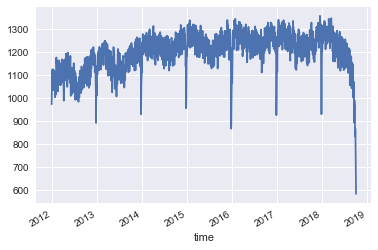

In [13]:
fm['count'].plot()

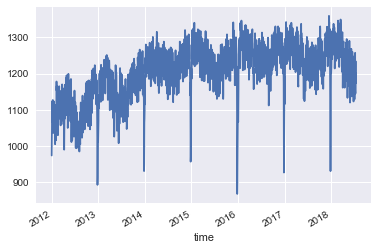

In [14]:
fm = fm[:-80]
fm['count'].plot()

In [15]:
fm.head()

,day,count,count_elec,count_nonelec,age_mean,age_std,age_skew,prop_nonelec
time,,,,,,,,
2012-01-01 07:00:00,2012-01-01,974.0,112.0,853.0,62.297741,26.585503,-0.897309,0.875770
2012-01-02 07:00:00,2012-01-02,1008.0,98.0,899.0,62.568452,26.251803,-0.901787,0.891865
2012-01-03 07:00:00,2012-01-03,1043.0,99.0,925.0,62.461170,26.026363,-0.868892,0.886865
2012-01-04 07:00:00,2012-01-04,1111.0,156.0,946.0,61.738074,26.454768,-0.862075,0.851485
2012-01-05 07:00:00,2012-01-05,1109.0,166.0,931.0,61.451758,26.787347,-0.844904,0.839495


## save features

In [16]:
def save_es_as_pickle(fm, features, name):
    " Take fm df and rename columns. Save as pickle."
    fm2 = fm
    for col in fm2.columns:
        fm2 = fm2.rename(columns={col:name + '_' + col})
    
    fm2.to_pickle('./../../../3_Data/EDclassification/processed/' + name + '.pkl')

fm.index = fm.index.shift(1,'d')

fm.head()

In [17]:
save_es_as_pickle(fm, 'test', 'IPmorn')

In [18]:
break

SyntaxError: 'break' outside loop (<ipython-input-18-6aaf1f276005>, line 1)

# morning es

In [ ]:
es['IPadm'].df.admission_date.min()

In [ ]:
fm.index.max()

In [ ]:
start = pd.datetime(2012,1,17,7)
# end = ED.arrival.max()
end = pd.datetime(2018,7,30,7)
ct = pd.DataFrame(pd.DatetimeIndex(freq='d',start=start,end=end),columns=['time'])
ct['day'] = ct.time.apply(lambda x: x.date())
ct.head()

In [ ]:
es['days'].df.head()

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='days',
                     trans_primitives=[],
#                      agg_primitives=['count','mean','std','num_true','sum'],
                     cutoff_time=ct)

# save_es_as_pickle(fm, features, 'EDmorn')

fm.head(3)

In [ ]:
save_es_as_pickle(fm, features, 'IPmorn')

In [ ]:
break

In [ ]:
start = pd.datetime(2011,1,1,7)
end = ED.arrival.max()
ct = pd.DataFrame(pd.DatetimeIndex(freq='d',start=start,end=end),columns=['time'])
ct['arr_date'] = ct.time.apply(lambda x: x.date())
ct.head()

ft.list_primitives().query('type == "aggregation"')

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='days',
                     trans_primitives=[],
                     agg_primitives=['count','mean','std','num_true','sum'],
                     cutoff_time=ct)

save_es_as_pickle(fm, features, 'EDmorn')

fm.head(3)

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='days',
                     trans_primitives=[],
                     agg_primitives=['count','mean','std','num_true','sum'],
#                      cutoff_time=ct,
                     )

fm.head(3)

In [ ]:
fm.index = fm.index.shift(1,'d')

In [ ]:
save_es_as_pickle(fm, features, 'EDprevday')

In [ ]:
break

In [ ]:
fm.head(3)

In [ ]:
fm.head(3)

In [ ]:
ct2 = ct.copy()
ct2.drop('time',axis=1,inplace=True)
ct2['time'] = pd.to_datetime(ct['arr_date'])

ct2.head(2)

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='days',
                     trans_primitives=['day','month'],
                     agg_primitives=['count','mean','std','num_true','sum'],
                     cutoff_time=ct2,
                     training_window = '24h')

fm.head(3)

In [ ]:
es['EDatt'].secondary_time_index

fm, features = ft.dfs(entityset=es,
                       target_entity='days')

fm.head()

Cutoff times on attendance ES

es.add_last_time_indexes()

In [ ]:
ED[ED.attendance_number == 91807209801]

In [ ]:
ct = pd.DataFrame()

# ct['arr_date'] = [pd.datetime(2018,9,3,0,0)]
ct['attendance_number'] = [91807209801]

ct['time'] = pd.to_datetime(['2018-09-3 00:07'])

In [ ]:
es['EDatt']

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='EDatt',
#                        cutoff_time=ct,
#                       cutoff_time_in_index=True, # just adds the cuttoff time to fm, if non given in ct df then its taken as now
#                      training_window="48 hours",
                     )
 

fm.head()

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='EDatt',
                       cutoff_time=ct,
                      cutoff_time_in_index=True, # just adds the cuttoff time to fm
                     training_window="48 hours",
                     )
 

fm

In [ ]:
ct = pd.DataFrame()

ct['arr_date'] = [pd.datetime(2018,9,3,0,0)]

ct['time'] = pd.to_datetime(['2018-09-02 06:00'])

In [ ]:
ct

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='EDatt',
                       cutoff_time=ct,
                      cutoff_time_in_index=True,
                     training_window="24 hours",
                     )
 

fm

In [ ]:
es['days']

# save out basic entities as pkl

es.to_pickle(pickle_path)

In [ ]:
break

# Create day features with cuttoffs for different times of day

In [ ]:
es

### create hourly - atten_no realationship

In [ ]:
hrly_atten_rel = es['EDatt'].df[['arrival','time_leaving_dept_inc_cdu']]
hrly_atten_rel['arrival'] = hrly_atten_rel['arrival'].apply(lambda x : x.replace(second=0,minute=0)) # round arrival hour down
hrly_atten_rel['time_leaving_dept_inc_cdu'] = hrly_atten_rel['time_leaving_dept_inc_cdu'].apply(lambda x : x.replace(second=0,minute=0)) +pd.Timedelta(hours=1) # round leaving tim up
hrly_atten_rel.head()

In [ ]:
hrly_atten_rel.head()

In [ ]:
hrly_atten_rel['n_hours'] = ((hrly_atten_rel['time_leaving_dept_inc_cdu'] - hrly_atten_rel['arrival'])/pd.Timedelta(1,'h')).astype(int)

In [ ]:
hrly_atten_rel.head()

In [ ]:
import itertools

In [ ]:
#### create a (long format) list of links between attendance numbers and 
#%%timeit



# function for list comp which finds list of datetimes (for each hour)
date_func = lambda datetime , offset : datetime + pd.Timedelta(offset,'h')

# iterate over rows in df
sample = hrly_atten_rel.head()
sample = sample.reset_index()

ids = np.empty(shape=(sample['n_hours'].sum()),dtype='int64') # initilise array - change to np.empty() to speed up
timestamps = np.empty(shape=(sample['n_hours'].sum()),dtype='datetime64[s]')
row_count = 0

for row in sample.itertuples():
    atten_id = [row[1]]
    hour_list = [date_func(row[2],i) for i in np.arange(row[4])] # creates list of hour datetimes
    
    # create array of list for all combinations of timestamp
    for i in itertools.product(atten_id,hour_list):
        ids[row_count] = i[0] # assign patient numbers
        timestamps[row_count] = i[1]
        row_count += 1 # add to row count for new array
        
print(ids)
print(timestamps)
ids.shape

In [ ]:
data = {'ids':ids,
       'timestamp':timestamps}

pd.DataFrame(data=data)

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='EDatt',
                       cutoff_time=ct,
                       cutoff_time_in_index=True,
                     max_depth=1,
                     training_window="1 hours")

fm

In [ ]:
#### put back into df
pd.DataFrame(data=[ids,timestamps],columns=['atten_id','timestamp'])

In [ ]:
sample.reset_index(inplace=True)

In [ ]:

#X = np.array()
for i in itertools.product(['1'],['2','3','4']):
    print(list(i))
    X[row[0]] = i
    
X

In [ ]:
import pandas as pd

In [ ]:

X.append()

In [ ]:
X = np.array([[1,2,3]])
X = np.append(X,[[3,4,5]],axis=0)
X

In [ ]:
ct=pd.DataFrame()

ct['attendance_number'] = [90902042301,90902042301,90902042301,90902042301,90902043501,90902043501]

ct['time'] = pd.to_datetime(['2009-4-1 02:00',
                             '2009-4-1 03:00',
                             '2009-4-1 04:00',
                             '2009-4-1 05:00',
                              '2009-4-1 07:00',
                              '2014-1-1 04:00'])

In [ ]:
ct

In [ ]:
es['EDpatients'].last_time_index = es['EDpatients'].df['last_time']

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='EDatt',
                       cutoff_time=ct,
                       cutoff_time_in_index=True,
                     max_depth=1,
                     training_window="1 hours")

fm

In [ ]:
es

In [ ]:
ct2 = es['EDatt'].df[['attendance_number','arrival','arrival_mode_desc_bool']].head(5)

In [ ]:
ft.__version__

In [ ]:
fm, features = ft.dfs(entityset=es,
                       target_entity='EDatt',
                       cutoff_time=ct2,
                       cutoff_time_in_index=True,
                     max_depth=2)

fm

In [ ]:
break

#### create a day table - by normalising a new feature

In [ ]:
es = es.normalize_entity(base_entity_id='EDatt',
                   new_entity_id="days",
                    index="arr_date")

#### import hourly table

In [ ]:
hrly = pd.read_pickle('./../3_Data/processed/sgh/sghHOURLY.pkl')

In [ ]:
hrly.columns

In [ ]:
hrly2 = hrly[['dt_date','EDocc_nonadmit', 'EDocc_admit', 'EDocc_total', 'EDocc_awaitingadm',
       'EDocc_nonbreach', 'EDocc_breach', 'IPocc_NonElective',
       'IPocc_Day_Case', 'IPocc_Elective', 'IPocc_total', 'IPocc_elec_nonelec',
       'IPadm', 'IPadm_nonelec', 'IPadm_daycase', 'IPadm_elective', 'IPdis',
       'IPdis_nonelec', 'IPdis_daycase', 'IPdis_elective',
       'IPadm_elec_nonelec', 'IPdis_elec_nonelec', 'EDarrive',
       'EDarrive_breach', 'EDarrive_adm', 'EDdepart', 'EDdepart_breach',
       'EDdepart_adm']].reset_index()

In [ ]:
es.entity_from_dataframe(entity_id='hourly',dataframe=hrly2,index='index')

In [ ]:
new_relationship = ft.Relationship(es["days"]["arr_date"],
                                    es["hourly"]["dt_date"])

es = es.add_relationship(new_relationship)

In [ ]:
es['hourly'].df.head(2)

# summary of esets

In [ ]:
es

In [ ]:
es['days'].df.head()

In [ ]:
es['EDatt'].df.head(2)

In [ ]:
es['patients'].df.head(3)

In [ ]:
es['hourly'].df.head(2)

In [ ]:
es['days'].df.head(3)

# make features

feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity='days',
      agg_primitives=['count','mean','num_true','sum'],
      trans_primitives=['month','year','day'],
    max_depth=1,n_jobs=2)

feature_matrix

In [ ]:
feature_matrix1, feature_defs = ft.dfs(entityset=es,target_entity='days',
      agg_primitives=['count','mean','num_true','sum','max','last'],
      trans_primitives=['month','year','weekend','weekday'],
    max_depth=1,n_jobs=1)

feature_matrix1.shape

In [ ]:
feature_matrix2, feature_defs = ft.dfs(entityset=es,target_entity='days',
      agg_primitives=['count','mean','num_true','sum','max','last'],
      trans_primitives=['month','year','weekend','weekday'],
    max_depth=2,n_jobs=1)

feature_matrix2.shape

In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity='days',
      agg_primitives=['count','mean','num_true','sum','max','last'],
      trans_primitives=['month','year','weekend','weekday'],
    max_depth=3,n_jobs=1)

feature_matrix.shape

In [ ]:
set(feature_matrix.columns) - set(feature_matrix1.columns)

In [ ]:
for i in feature_matrix.columns:
    print(i)

In [ ]:
feature_matrix.shape

In [ ]:
feature_matrix.shape

## do some basic drops

In [ ]:
uniques = feature_matrix.apply(lambda x: x.nunique())

In [ ]:
uniques[uniques==1].index

In [ ]:
feature_matrix = feature_matrix.drop(uniques[uniques==1].index, axis=1)

#### drop columns which have all same values

In [ ]:
feature_matrix.shape

In [ ]:
cols = list(feature_matrix)
nunique = feature_matrix.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
feature_matrix.drop(cols_to_drop, axis=1,inplace=True)

In [ ]:
feature_matrix.shape

#### drop cols that are duplicated 

In [ ]:
from utils import duplicate_columns

In [ ]:
dups = duplicate_columns(feature_matrix)
dups

In [ ]:
feature_matrix.drop(dups,axis=1,inplace=True)

In [ ]:
feature_matrix.shape

### save out

In [ ]:
pd.to_pickle(feature_matrix,'./activity.pkl')

In [ ]:
ft.list_primitives().head(40)

In [ ]:
ft.list_primitives().tail(40).loc[22].description

# Dev

In [ ]:
break

In [ ]:
ED.columns

#### create and link day table - by adding a new df

from core import create_timeseries_from_events

ED.columns

start = ED.tail(i).arrival.min().round('D')
end = ED.tail(i).arrival.max().round('D')

occED = create_timeseries_from_events(ED.tail(i),'arrival','time_leaving_dept_inc_cdu',col_to_split='admission_flag',start=start,end=end,freq='H')

occED['EDocc_MEAN'] = occED.sum(axis=1) # make agg col

occED['day'] = occED.index.round('D')

occEDday = occED.groupby(['day']).mean()

occEDday.index

day = occEDday['EDocc_MEAN'].reset_index()

day.head(2)

#### add to es

es = es.entity_from_dataframe(entity_id="days",dataframe=day,
                              index="day",
                              time_index="day")

new_relationship = ft.Relationship(es["days"]["day"],
                                   es["ED_atten"]["arr_date"])

es = es.add_relationship(new_relationship)

#### Look at tables

In [ ]:
es['days'].df.head()

es['days'].df['day'].head()

es['days'].df['day'].dtype

es['ED_atten'].index

es['ED_atten'].df.arrival.dtype

es['patient'].df.columns #.dtype

es['patient'].df['first_ED_atten_time'].dtype

In [ ]:
es['ED_atten']

In [ ]:
es['patient']

In [ ]:
es['days']

es['days']

In [ ]:
es

# DFS

### create range of datetimes for arrival in df

In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity="days")

In [ ]:
feature_matrix

In [ ]:
window_fm, window_features = ft.dfs(entityset=es,target_entity='days',cutoff_time=ct,
       cutoff_time_in_index=True,
      training_window = '24 hours')

In [ ]:
pd.DatetimeIndex(start=start,end=end,freq='D')

In [ ]:
ft.list_primitives().head(40)